### Font type Recognition using Feed Forward Network

In [34]:
import tensorflow as tf
import numpy as np
import math

%autoindent

In [35]:
!python -m pip install tqdm

In [36]:
from tqdm import tqdm, tqdm_notebook

In [37]:
import time
for i in tqdm_notebook(range(100)):
    time.sleep(.1)

### Data: 2790 36x36 images

In [38]:
# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']


In [39]:
data['arr_0'].shape

(2790, 36, 36)

In [40]:
# Look at some data
print(train[0])
print(labels[0])

# If you have matplotlib installed
import matplotlib.pyplot as plt
%matplotlib inline

plt.ion()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


In [41]:
def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.

    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

In [42]:
# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx,training_idx=indices[:valid_cnt],indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

In [43]:
sess = tf.InteractiveSession()

# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])

# Hidden layer 1
num_hidden1 = 128
W1 = tf.Variable(tf.truncated_normal([1296,num_hidden1],
                               stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_hidden1]))
h1 = tf.sigmoid(tf.matmul(x,W1) + b1)

# Hidden Layer 2
num_hidden2 = 32
W2 = tf.Variable(tf.truncated_normal([num_hidden1,
            num_hidden2],stddev=2./math.sqrt(num_hidden1)))
b2 = tf.Variable(tf.constant(0.2,shape=[num_hidden2]))
h2 = tf.sigmoid(tf.matmul(h1,W2) + b2)

# Output Layer
W3 = tf.Variable(tf.truncated_normal([num_hidden2, 5],
                                   stddev=1./math.sqrt(5)))
b3 = tf.Variable(tf.constant(0.1,shape=[5]))

# Just initialize
#sess.run(tf.initialize_all_variables())
sess.run(tf.global_variables_initializer())

# Define model
y = tf.nn.softmax(tf.matmul(h2,W3) + b3)

### End model specification, begin training code


# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
     tf.nn.softmax_cross_entropy_with_logits(y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [45]:
# Actually train
epochs = 250
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})
        train_acc[i//10] = A

        # And now the validation set
        A = accuracy.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test})
        test_acc[i//10] = A

    train_step.run(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})

100%|##########| 250/250 [00:13<00:00, 18.83it/s]


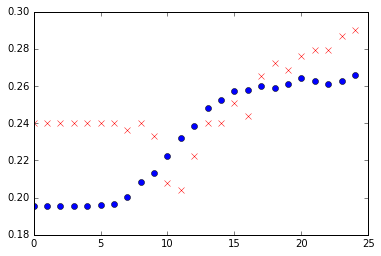

In [46]:
# Plot the accuracy curves
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

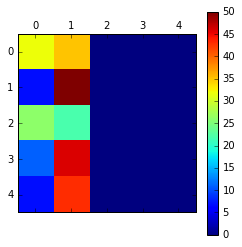

In [47]:
# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

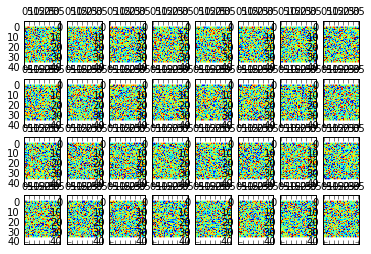

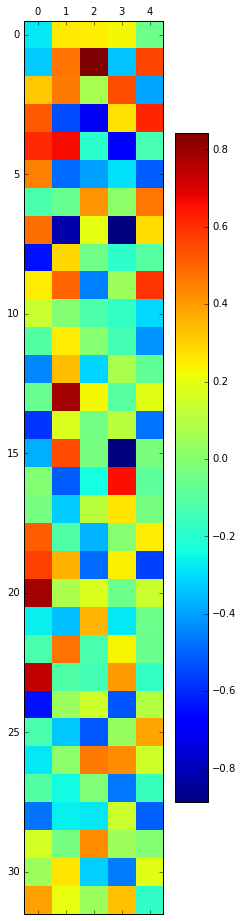

In [48]:
# Let's look at a subplot of some weights
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].matshow(W1.eval()[:,i].reshape([36,36]))

# Examine the output weights
plt.matshow(W3.eval())
plt.colorbar()

In [49]:
# Save the weights
saver = tf.train.Saver()
saver.save(sess, "/resources/data/mpl.ckpt")

'/resources/data/mpl.ckpt'

In [50]:
# Save the variables to disk.
save_path = saver.save(sess, "/resources/data/mpl.ckpt")
print("Model saved in file: %s" % save_path)


Model saved in file: /resources/data/mpl.ckpt


In [51]:
sess.close()

### <font color='red'>This must be solved! </font>

In [52]:

with tf.Session() as sess:# Restore
    saver.restore(sess, "/resources/data/mlp.ckpt")

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /resources/data/mlp.ckpt
	 [[Node: save_2/RestoreV2_4 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_2/Const_0, save_2/RestoreV2_4/tensor_names, save_2/RestoreV2_4/shape_and_slices)]]

Caused by op u'save_2/RestoreV2_4', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-2ae4b4a0055a>", line 2, in <module>
    saver = tf.train.Saver()
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /resources/data/mlp.ckpt
	 [[Node: save_2/RestoreV2_4 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_2/Const_0, save_2/RestoreV2_4/tensor_names, save_2/RestoreV2_4/shape_and_slices)]]
